In [1]:
import pickle
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict
import math
import ast
import requests
import json
import os

## Load in Results

In [2]:
#with open('/content/results-equal_frequency-1611846814.7269607.pk', 'rb') as f_:
#  res = pickle.load(f_)
scripts_dir = os.path.join(os.getcwd(), '..', 'scripts')
with open(os.path.join(scripts_dir, 'results-equal_frequency-1622273453.6398165.pk'), 'rb') as f_:
    res = pickle.load(f_)
#with open('/mnt/c/Users/c_yak/OneDrive - Dartmouth College/Desktop/top_gene_drugs.pk', 'rb') as f_:
with open(os.path.join(scripts_dir, 'top_gene_drugs.pk'), 'rb') as f_:
    top_genes, top_drugs = pickle.load(f_)
with open(os.path.join(scripts_dir, 'parsed-drug_contrib_results.pk'), 'rb') as f_:
    drug_contribs = pickle.load(f_)

In [3]:
# Format top genes and drugs
top_genes = [gene[1:] for gene in top_genes]
top_drugs = [drug[13:] for drug in top_drugs]

In [4]:
r = json.loads(requests.get("http://chp.thayer.dartmouth.edu/curies").content)

In [5]:
gene_map = r["biolink:Gene"]

## Analysis Functions

In [6]:
def read_in_results(_res, normalize=True):
    data = defaultdict(list)
    ranges_set = set()
    for (gene, drug), feature_updates in _res.items():
        for feature, updates in feature_updates.items():
            if normalize:
                total_prob = 0
                for update_name, prob in updates.items():
                    if prob > 0:
                        total_prob += prob
            else:
                total_prob = 1
            if total_prob > 0:
                data["Gene Curie"].append(gene[1:])
                data["Drug Curie"].append(drug[13:])
                data["Total Prob"].append(total_prob)
                for update_name, prob in updates.items():
                    ranges_set.add(update_name)
                    if prob >= 0:
                        data[update_name].append(prob/total_prob)
                    else:
                        data[update_name].append(prob)
                    data["{}-unnorm".format(update_name)].append(prob)
    df = pd.DataFrame.from_dict(dict(data))
    df = df.replace(to_replace=-1, value=np.nan)
    ranges = []
    for range_str in ranges_set:
        ranges.append(ast.literal_eval(range_str))
    order = [str(_range) for _range in sorted(ranges)]
    return df, order

def build_heat(_res, normalize=True, _top_drugs=None, _top_genes=None):
    # Read in raw data
    data_df, order = read_in_results(_res)
    # Build Heat Map Dataframe (heat indices)
    data_df = data_df.fillna(0)
    heat_list = []
    for i, _range in enumerate(order):
        heat_list.append(data_df[_range]*(i+1))
    #heat = data_2_zeros[order[0]] + data_2_zeros[order[1]]*2 + data_2_zeros["(3296.5, 4944.8)"]*3 + data_2_zeros["(4944.8, 6593.0)"]*4 + data_2_zeros[">=6593.0"]*5
    data_df["Heat"] = sum(heat_list)
    data_heat = data_df.drop(labels=order, axis=1).pivot(
        index="Gene Curie",
        columns="Drug Curie",
        values="Heat"
    )
    # Filter out based on top drug or genes
    if _top_drugs is not None:
        data_heat = data_heat[_top_drugs]
    if _top_genes is not None:
        data_heat = data_heat.reindex(index=_top_genes)
    # Convert to average predicted survival
    data_dict = data_heat.to_dict()
    for drug, gene_value_dict in data_dict.items():
        for gene, value in gene_value_dict.items():
            # Get ranges
            try:
                low_idx = int(np.floor(value)) - 1
                high_idx = int(np.ceil(value)) - 1
                frac = value - low_idx
                range_low = ast.literal_eval(order[low_idx])
                range_high = ast.literal_eval(order[high_idx])
                combined_range = (range_low[0], range_high[1])
                mean_surv = combined_range[0] + ((combined_range[1] - combined_range[0]) * frac)
                data_dict[drug][gene] = mean_surv / 365
            except ValueError:
                data_dict[drug][gene] = np.nan

    heat_df = pd.DataFrame.from_dict(data_dict)
    return heat_df, data_df

def plot_heat_map(_heat_df):
    f, ax = plt.subplots(figsize=(20,10))
    sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
    sns.set(font_scale=3)
    #f, ax = plt.subplots(figsize=(9, 6))
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(_heat_df.T, xticklabels=False, yticklabels=True, cbar_kws={'label': 'Survival Time (Years)'}, mask=heat_df.T.isna())
    ax.set_ylabel('CHEMBL Drug Curie Identifiers')
    ax.set_xlabel('Mutated Genes')
    ax.set_title('Average Predicted Survival Time')
    ax.labelsize='large'
    ax.titlesize='large'
    plt.show()
    
def get_bottom_fraction_genes(_heat_df, below_fraction, invert=False):
    heat_quantile = heat_df.quantile(below_fraction)
    btm_genes = {}
    for drug in heat_quantile.index:
        if invert:
            btm_genes[drug] = set(heat_df[heat_df[drug] > heat_quantile[drug]][drug].index)
        else:
             btm_genes[drug] = set(heat_df[heat_df[drug] < heat_quantile[drug]][drug].index)
    return btm_genes
    
def get_genes(_heat_df, below_fraction, drugs=None, invert=False):
    btm_genes = get_bottom_fraction_genes(_heat_df, below_fraction, invert)
    if drugs is None:
        return btm_genes
    else:
        return set.intersection(*[btm_genes[drug] for drug in drugs])

def get_differential_genes(_heat_df, below_fraction_1, below_fraction_2, drugset_1, drugset_2, invert=False):
    geneset_1 = get_genes(_heat_df, below_fraction_1, drugs=drugset_1, invert=invert)
    geneset_2 = get_genes(_heat_df, below_fraction_2, drugs=drugset_2, invert=invert)
    return geneset_1.difference(geneset_2)

def print_genes(gene_set):
    for _id in gene_set:
        print(_id, gene_map[_id][0])

# Analysis
Below is the gene drug analysis for the bioinformatics paper.

In [7]:
heat_df, data_df = build_heat(res, _top_drugs=top_drugs, _top_genes=top_genes)

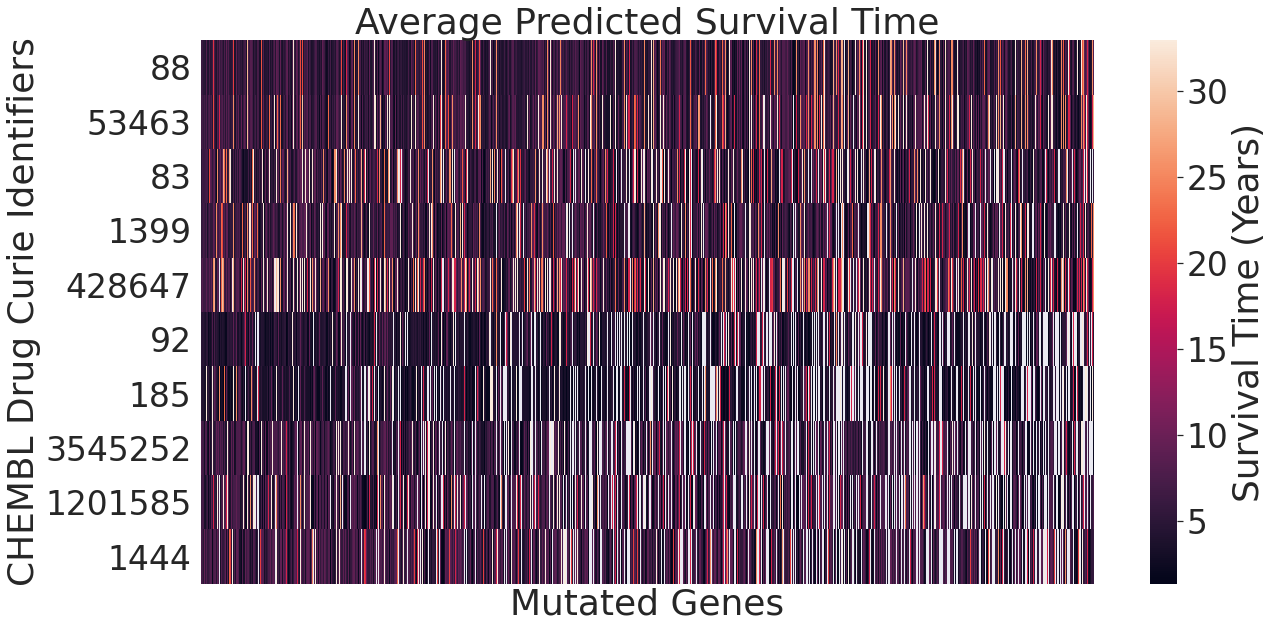

In [10]:
plot_heat_map(heat_df)

Let's look at the genes that show up in bottom 25% in terms of predicted average survival time for **interruption of mitosis via microtubule targeting** drugs.

In [11]:
bad_genes = get_genes(heat_df, .25, drugs=['3545252','428647', '92'])
print_genes(bad_genes)

ENSEMBL:ENSG00000198169 ZNF251
ENSEMBL:ENSG00000138160 KIF11
ENSEMBL:ENSG00000174145 NWD2
ENSEMBL:ENSG00000160145 KALRN
ENSEMBL:ENSG00000119778 ATAD2B
ENSEMBL:ENSG00000109819 PPARGC1A
ENSEMBL:ENSG00000115970 THADA
ENSEMBL:ENSG00000102452 NALCN
ENSEMBL:ENSG00000138646 HERC5
ENSEMBL:ENSG00000158352 SHROOM4
ENSEMBL:ENSG00000140262 TCF12


In [14]:
for g in bad_genes:
    print(heat_df.loc[g])

88         3.001346
53463      8.346086
83         4.124030
1399       9.063548
428647     3.233478
92         1.953431
185        3.186731
3545252    3.189007
1201585    7.650073
1444       8.106600
Name: ENSEMBL:ENSG00000198169, dtype: float64
88          7.295582
53463      32.928582
83          7.294515
1399        7.295620
428647      1.945205
92          1.945205
185         6.531507
3545252     1.945205
1201585     1.945205
1444             NaN
Name: ENSEMBL:ENSG00000138160, dtype: float64
88         2.596277
53463      2.919620
83         5.829406
1399       5.513409
428647     1.946131
92         1.945752
185             NaN
3545252    1.945205
1201585    1.945205
1444       5.512329
Name: ENSEMBL:ENSG00000174145, dtype: float64
88         3.188076
53463      3.187525
83         3.187458
1399       3.186301
428647     3.187895
92         1.945205
185        1.945205
3545252    3.186517
1201585         NaN
1444       5.512329
Name: ENSEMBL:ENSG00000160145, dtype: float64
88    

In [18]:
bad_genes_all = get_genes(heat_df, .4, drugs=['88','53463','83','1399','185', '1201585','1444'])
print_genes(bad_genes_all)
print()
print_genes(bad_genes - bad_genes_all)

ENSEMBL:ENSG00000118473 SGIP1
ENSEMBL:ENSG00000151952 TMEM132D
ENSEMBL:ENSG00000115020 PIKFYVE
ENSEMBL:ENSG00000164418 GRIK2
ENSEMBL:ENSG00000023287 RB1CC1
ENSEMBL:ENSG00000116748 AMPD1

ENSEMBL:ENSG00000138160 KIF11
ENSEMBL:ENSG00000138646 HERC5
ENSEMBL:ENSG00000119778 ATAD2B
ENSEMBL:ENSG00000115970 THADA
ENSEMBL:ENSG00000140262 TCF12
ENSEMBL:ENSG00000102452 NALCN
ENSEMBL:ENSG00000160145 KALRN
ENSEMBL:ENSG00000174145 NWD2
ENSEMBL:ENSG00000198169 ZNF251
ENSEMBL:ENSG00000158352 SHROOM4
ENSEMBL:ENSG00000109819 PPARGC1A


Let's look at the genes that perform lowest (bottom 25%) and are different between taxol drugs and other microtubal drugs.

In [153]:
pac_genes = get_differential_genes(heat_df, .95, .75,  ['428647'], ['3545252', '92'], invert=True)
print_genes(pac_genes)

ENSEMBL:ENSG00000180287 PLD5
ENSEMBL:ENSG00000102935 ZNF423
ENSEMBL:ENSG00000149294 NCAM1
ENSEMBL:ENSG00000152527 PLEKHH2
ENSEMBL:ENSG00000082293 COL19A1
ENSEMBL:ENSG00000171903 CYP4F11
ENSEMBL:ENSG00000151835 SACS
ENSEMBL:ENSG00000143199 ADCY10
ENSEMBL:ENSG00000176601 MAP3K19
ENSEMBL:ENSG00000135945 REV1
ENSEMBL:ENSG00000148513 ANKRD30A
ENSEMBL:ENSG00000162951 LRRTM1
ENSEMBL:ENSG00000130226 DPP6
ENSEMBL:ENSG00000244405 ETV5
ENSEMBL:ENSG00000135111 TBX3
ENSEMBL:ENSG00000188158 NHS
ENSEMBL:ENSG00000159216 RUNX1
ENSEMBL:ENSG00000197472 ZNF695
ENSEMBL:ENSG00000077235 GTF3C1
ENSEMBL:ENSG00000143669 LYST
ENSEMBL:ENSG00000125207 PIWIL1
ENSEMBL:ENSG00000160321 ZNF208
ENSEMBL:ENSG00000143297 FCRL5
ENSEMBL:ENSG00000243244 STON1
ENSEMBL:ENSG00000152580 IGSF10
ENSEMBL:ENSG00000147050 KDM6A
ENSEMBL:ENSG00000115850 LCT
ENSEMBL:ENSG00000116128 BCL9
ENSEMBL:ENSG00000180336 C17orf104
ENSEMBL:ENSG00000137474 MYO7A
ENSEMBL:ENSG00000147459 DOCK5
ENSEMBL:ENSG00000198796 ALPK2
ENSEMBL:ENSG00000167632 TRAPP

In [183]:
heat_df.loc['ENSEMBL:ENSG00000091656']

88          4.521391
53463       4.521867
83         32.775860
1399        5.514612
428647      3.190163
92          5.051391
185         3.190137
3545252     3.552135
1201585     3.808056
1444       20.150973
Name: ENSEMBL:ENSG00000091656, dtype: float64

In [193]:
heat_df.quantile(.25)

88         4.118579
53463      4.120623
83         4.119276
1399       3.568055
428647     4.122235
92         3.186301
185        2.917963
3545252    3.190358
1201585    3.188775
1444       5.512329
Name: 0.25, dtype: float64

In [20]:
'ENSEMBL:ENSG00000156113' in gene_map

True

In [21]:
r_meta = json.loads(requests.get("http://chp.thayer.dartmouth.edu/meta_knowledge_graph").content)

In [22]:
r_meta

{'nodes': {'biolink:Gene': {'id_prefixes': ['ENSEMBL']},
  'biolink:Drug': {'id_prefixes': ['CHEMBL']},
  'biolink:Disease': {'id_prefixes': ['MONDO']},
  'biolink:PhenotypicFeature': {'id_prefixes': ['EFO']}},
 'edges': [{'subject': 'biolink:Gene',
   'predicate': 'biolink:gene_associated_with_condition',
   'object': 'biolink:Disease'},
  {'subject': 'biolink:Gene',
   'predicate': 'biolink:interacts_with',
   'object': 'biolink:Drug'},
  {'subject': 'biolink:Drug',
   'predicate': 'biolink:treats',
   'object': 'biolink:Disease'},
  {'subject': 'biolink:Drug',
   'predicate': 'biolink:interacts_with',
   'object': 'biolink:Gene'},
  {'subject': 'biolink:Disease',
   'predicate': 'biolink:has_phenotype',
   'object': 'biolink:PhenotypicFeature'}]}

# Old Work

In [154]:
def convert_res_to_df(_res):
  data = defaultdict(list)
  for (gene, drug), feature_updates in _res.items():
    for feature, updates in feature_updates.items():
      for update_name, prob in updates.items():
        data["Gene Curie"].append(gene[1:])
        data["Drug Curie"].append(drug[13:])
        data["Survival Time Range (days)"].append(update_name)
        data["Log Probability"].append(math.log(prob) if prob > 0 else -1)
  df = pd.DataFrame.from_dict(dict(data))
  df = df.replace(to_replace=-1, value=0)
  return df

In [155]:
set1 = {'A', 'B', 'C'}
set2 = {'A', 'B'}

set1.difference(set2)

{'C'}

In [156]:
data = convert_res_to_df(res)

In [157]:
data[data["Drug Curie"] == '88']

,Gene Curie,Drug Curie,Survival Time Range (days),Log Probability
0,ENSEMBL:ENSG00000121879,88,"(1163.0, 2012.0)",-3.520639
1,ENSEMBL:ENSG00000121879,88,"(710.0, 1163.0)",-3.572362
2,ENSEMBL:ENSG00000121879,88,"(2012.0, 6593.0)",-3.241674
3,ENSEMBL:ENSG00000121879,88,"(482.0, 710.0)",-3.420673
4,ENSEMBL:ENSG00000121879,88,"(0.0, 482.0)",-3.896523
...,...,...,...,...
49950,ENSEMBL:ENSG00000127329,88,"(1163.0, 2012.0)",-6.466485
49951,ENSEMBL:ENSG00000127329,88,"(710.0, 1163.0)",-12.411985
49952,ENSEMBL:ENSG00000127329,88,"(2012.0, 6593.0)",-5.773357
49953,ENSEMBL:ENSG00000127329,88,"(482.0, 710.0)",-12.265714


In [158]:
dims = (30, 10)
ranges = []
for range_str in data["Survival Time Range (days)"].unique():
  ranges.append(ast.literal_eval(range_str))
order = [str(_range) for _range in sorted(ranges)]
order


['(0.0, 482.0)',
 '(482.0, 710.0)',
 '(710.0, 1163.0)',
 '(1163.0, 2012.0)',
 '(2012.0, 6593.0)']

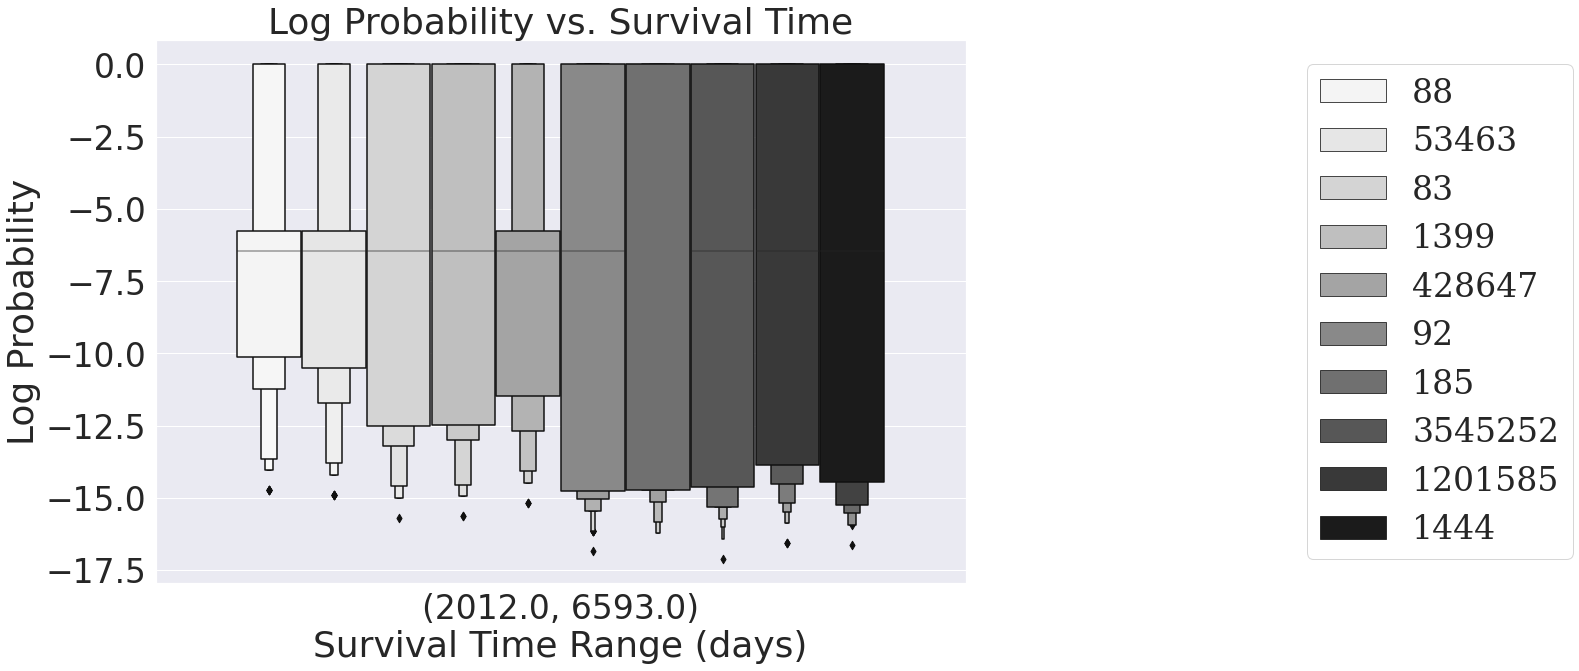

In [159]:
#sns.set_theme(style="ticks", palette="pastel")
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale=3)
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
g = sns.boxenplot(
    ax=ax,
    x="Survival Time Range (days)",
    y="Log Probability",
    hue="Drug Curie",
    order=order[4:],
    data=data,
    palette='Greys',
    )
g.legend(loc='center right', bbox_to_anchor=(1.77, 0.5), ncol=1)
ax.set_title('Log Probability vs. Survival Time')
ax.labelsize='large'
ax.titlesize='large'
#fig.set_size_inches(10, 5.5)     # set a suitable size
plt.subplots_adjust(right=.5)  # adjust plot area
fig.savefig('boxplot.png')
plt.show()

In [160]:
def convert_res_to_df2(_res, normalize=True):
  _data = defaultdict(list)
  for (gene, drug), feature_updates in _res.items():
    for feature, updates in feature_updates.items():
      if normalize:
        total_prob = 0
        for update_name, prob in updates.items():
          if prob > 0:
            total_prob += prob
      else:
        total_prob = 1
      #print(total_prob)
      #input()
      if total_prob > 0:
        _data["Gene Curie"].append(gene[1:])
        _data["Drug Curie"].append(drug[13:])
        _data["Total Prob"].append(total_prob)
        for update_name, prob in updates.items():
          if prob >= 0:
            _data[update_name].append(prob/total_prob)
          else:
            _data[update_name].append(prob)
          _data["{}-unnorm".format(update_name)].append(prob)
  df = pd.DataFrame.from_dict(dict(_data))
  df = df.replace(to_replace=-1, value=np.nan)
  return df

In [161]:
data_2 = convert_res_to_df2(res, normalize=True)

In [162]:
data_2

,Gene Curie,Drug Curie,Total Prob,"(1163.0, 2012.0)","(1163.0, 2012.0)-unnorm","(710.0, 1163.0)","(710.0, 1163.0)-unnorm","(2012.0, 6593.0)","(2012.0, 6593.0)-unnorm","(482.0, 710.0)","(482.0, 710.0)-unnorm","(0.0, 482.0)","(0.0, 482.0)-unnorm"
0,ENSEMBL:ENSG00000121879,88,1.497712e-01,0.197505,2.958052e-02,0.187549,2.808943e-02,0.261054,3.909838e-02,0.218269,3.269042e-02,0.135623,2.031241e-02
1,ENSEMBL:ENSG00000121879,53463,1.106051e-01,0.211121,2.335110e-02,0.154989,1.714258e-02,0.282542,3.125065e-02,0.252779,2.795867e-02,0.098568,1.090213e-02
2,ENSEMBL:ENSG00000121879,83,1.070814e-01,0.231892,2.483129e-02,0.159435,1.707251e-02,0.145079,1.553530e-02,0.246363,2.638092e-02,0.217231,2.326139e-02
3,ENSEMBL:ENSG00000121879,1399,9.778149e-02,0.190439,1.862138e-02,0.317321,3.102815e-02,0.143053,1.398795e-02,0.253939,2.483053e-02,0.095248,9.313476e-03
4,ENSEMBL:ENSG00000121879,428647,6.536868e-02,0.214020,1.399023e-02,0.166578,1.088895e-02,0.286891,1.875366e-02,0.261219,1.707555e-02,0.071292,4.660286e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,ENSEMBL:ENSG00000127329,92,1.505574e-06,0.128713,1.937868e-07,0.217822,3.279469e-07,0.128713,1.937868e-07,0.257426,3.875736e-07,0.267327,4.024803e-07
8925,ENSEMBL:ENSG00000127329,185,1.080734e-06,0.248276,2.683202e-07,0.144828,1.565201e-07,NaN,NaN,0.110345,1.192534e-07,0.496552,5.366404e-07
8926,ENSEMBL:ENSG00000127329,3545252,1.550947e-03,0.000077,1.192534e-07,0.000077,1.192534e-07,0.000096,1.490668e-07,0.000062,9.689340e-08,0.999688,1.550462e-03
8927,ENSEMBL:ENSG00000127329,1201585,8.720406e-07,0.384615,3.354002e-07,NaN,NaN,0.290598,2.534135e-07,0.256410,2.236002e-07,0.068376,5.962671e-08


In [163]:
.077233 / .115277

0.6699775323785316

In [164]:
data_2 = data_2.fillna(0)
heat_list = []
for i, _range in enumerate(order):
  heat_list.append(data_2[_range]*(i+1))
#heat = data_2_zeros[order[0]] + data_2_zeros[order[1]]*2 + data_2_zeros["(3296.5, 4944.8)"]*3 + data_2_zeros["(4944.8, 6593.0)"]*4 + data_2_zeros[">=6593.0"]*5

heat = sum(heat_list)
data_2["Heat"] = heat

In [165]:
data_2

,Gene Curie,Drug Curie,Total Prob,"(1163.0, 2012.0)","(1163.0, 2012.0)-unnorm","(710.0, 1163.0)","(710.0, 1163.0)-unnorm","(2012.0, 6593.0)","(2012.0, 6593.0)-unnorm","(482.0, 710.0)","(482.0, 710.0)-unnorm","(0.0, 482.0)","(0.0, 482.0)-unnorm",Heat
0,ENSEMBL:ENSG00000121879,88,1.497712e-01,0.197505,2.958052e-02,0.187549,2.808943e-02,0.261054,3.909838e-02,0.218269,3.269042e-02,0.135623,2.031241e-02,3.230098
1,ENSEMBL:ENSG00000121879,53463,1.106051e-01,0.211121,2.335110e-02,0.154989,1.714258e-02,0.282542,3.125065e-02,0.252779,2.795867e-02,0.098568,1.090213e-02,3.326291
2,ENSEMBL:ENSG00000121879,83,1.070814e-01,0.231892,2.483129e-02,0.159435,1.707251e-02,0.145079,1.553530e-02,0.246363,2.638092e-02,0.217231,2.326139e-02,2.841225
3,ENSEMBL:ENSG00000121879,1399,9.778149e-02,0.190439,1.862138e-02,0.317321,3.102815e-02,0.143053,1.398795e-02,0.253939,2.483053e-02,0.095248,9.313476e-03,3.032110
4,ENSEMBL:ENSG00000121879,428647,6.536868e-02,0.214020,1.399023e-02,0.166578,1.088895e-02,0.286891,1.875366e-02,0.261219,1.707555e-02,0.071292,4.660286e-03,3.383998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8924,ENSEMBL:ENSG00000127329,92,1.505574e-06,0.128713,1.937868e-07,0.217822,3.279469e-07,0.128713,1.937868e-07,0.257426,3.875736e-07,0.267327,4.024803e-07,2.594059
8925,ENSEMBL:ENSG00000127329,185,1.080734e-06,0.248276,2.683202e-07,0.144828,1.565201e-07,0.000000,0.000000e+00,0.110345,1.192534e-07,0.496552,5.366404e-07,2.144828
8926,ENSEMBL:ENSG00000127329,3545252,1.550947e-03,0.000077,1.192534e-07,0.000077,1.192534e-07,0.000096,1.490668e-07,0.000062,9.689340e-08,0.999688,1.550462e-03,1.000831
8927,ENSEMBL:ENSG00000127329,1201585,8.720406e-07,0.384615,3.354002e-07,0.000000,0.000000e+00,0.290598,2.534135e-07,0.256410,2.236002e-07,0.068376,5.962671e-08,3.572650


In [166]:
data_heat = data_2.drop(labels=order, axis=1).pivot(
    index="Gene Curie",
    columns="Drug Curie",
    values="Heat"
)

In [167]:
data_heat

Drug Curie,1201585,1399,1444,185,3545252,428647,53463,83,88,92
Gene Curie,,,,,,,,,,
ENSEMBL:ENSG00000001626,1.000440,3.413580,4.140351,1.000461,2.196078,3.001339,3.003010,3.289318,2.253384,2.409449
ENSEMBL:ENSG00000002746,NaN,3.999793,3.000000,NaN,NaN,3.999923,3.249985,4.000000,3.333331,2.500070
ENSEMBL:ENSG00000005108,1.007525,3.973691,3.000912,2.554252,3.611111,3.829268,1.557846,1.063461,1.397656,1.011615
ENSEMBL:ENSG00000005483,3.482213,1.039132,2.500971,2.554252,3.611111,3.997807,3.011067,3.978557,3.011525,2.707018
ENSEMBL:ENSG00000005810,3.572650,1.029350,3.061224,1.000797,3.276316,3.857531,1.346883,1.752686,1.214124,1.003090
...,...,...,...,...,...,...,...,...,...,...
ENSEMBL:ENSG00000275395,3.572650,4.329950,2.000999,3.997417,3.276316,3.251066,3.400650,4.330879,3.498112,3.997275
ENSEMBL:ENSG00000277399,NaN,3.333333,2.500043,NaN,NaN,5.000000,3.999628,4.500000,3.999435,NaN
ENSEMBL:ENSG00000278540,2.000000,4.333228,3.999827,NaN,3.179487,4.666772,4.666672,3.999748,4.666098,NaN


In [168]:
#data_heat = data_heat.dropna()
data_heat2 = data_heat[top_drugs]
data_heat3 = data_heat2.reindex(index=top_genes)
#data_heat3 = data_heat3.dropna()

In [169]:
data_heat3

Drug Curie,88,53463,83,1399,428647,92,185,3545252,1201585,1444
Gene Curie,,,,,,,,,,
ENSEMBL:ENSG00000121879,3.230098,3.326291,2.841225,3.032110,3.383998,2.896105,2.893625,3.642338,3.210864,3.473735
ENSEMBL:ENSG00000141510,3.173318,3.377403,3.330436,3.129138,3.666904,2.678617,2.476360,3.388970,3.449986,3.286531
ENSEMBL:ENSG00000155657,2.960714,3.069356,3.174237,3.365567,3.238686,2.817874,2.500155,3.333772,3.375155,2.876250
ENSEMBL:ENSG00000181143,2.964955,3.377984,3.185937,3.249081,3.253008,2.500701,2.001403,2.002781,1.835834,3.999172
ENSEMBL:ENSG00000039068,2.645952,3.011371,3.329998,3.001414,3.227618,1.837107,1.671252,3.611111,2.016934,3.001628
...,...,...,...,...,...,...,...,...,...,...
ENSEMBL:ENSG00000129534,1.667299,1.667145,4.000000,1.999798,1.500106,NaN,4.000000,NaN,2.000000,2.000000
ENSEMBL:ENSG00000129351,2.000701,2.000000,NaN,3.000000,2.000000,4.000000,NaN,NaN,NaN,3.000000
ENSEMBL:ENSG00000129292,2.500827,2.500799,2.000531,4.323308,3.000000,NaN,1.000000,NaN,4.000000,4.000000


In [170]:
# Convert to survival time mean based on ranges
data_dict = data_heat3.to_dict()
for drug, gene_value_dict in data_dict.items():
  for gene, value in gene_value_dict.items():
    # Get ranges
    try:
      low_idx = int(np.floor(value)) - 1
      high_idx = int(np.ceil(value)) - 1
      frac = value - low_idx
      range_low = ast.literal_eval(order[low_idx])
      range_high = ast.literal_eval(order[high_idx])
      combined_range = (range_low[0], range_high[1])
      mean_surv = combined_range[0] + ((combined_range[1] - combined_range[0]) * frac)
      data_dict[drug][gene] = mean_surv / 365
    except ValueError:
      data_dict[drug][gene] = np.nan

heat_df = pd.DataFrame.from_dict(data_dict)
heat_df

,88,53463,83,1399,428647,92,185,3545252,1201585,1444
ENSEMBL:ENSG00000121879,6.333117,6.676249,4.755821,5.626870,6.882096,4.858213,4.853584,7.803627,6.264508,7.202200
ENSEMBL:ENSG00000141510,6.130574,6.858573,6.691034,5.972980,7.891259,4.452432,4.075071,6.899832,7.117485,6.534420
ENSEMBL:ENSG00000155657,4.978756,5.759729,6.133853,6.816351,6.363750,4.712253,4.119467,6.702933,6.850552,4.821168
ENSEMBL:ENSG00000181143,4.986669,6.860644,6.175589,6.400833,6.414840,4.120486,3.188919,3.191489,3.571074,9.076500
ENSEMBL:ENSG00000039068,4.391488,5.552890,6.689471,5.517372,6.324272,3.573551,3.250928,7.692237,3.217896,5.518138
...,...,...,...,...,...,...,...,...,...,...
ENSEMBL:ENSG00000129534,3.243239,3.242941,5.512329,3.890019,2.918015,NaN,5.512329,NaN,1.945205,1.945205
ENSEMBL:ENSG00000129351,3.187610,1.945205,NaN,3.186301,1.945205,5.512329,NaN,NaN,NaN,3.186301
ENSEMBL:ENSG00000129292,4.120722,4.120668,3.187292,22.872778,3.186301,NaN,1.320548,NaN,5.512329,5.512329
ENSEMBL:ENSG00000127507,25.493579,18.069517,NaN,5.512329,18.063014,18.063943,32.932861,NaN,5.512329,5.512329


In [171]:
pac = heat_df['428647']
sort_ = pac.sort_values()
pac.describe()

count    958.000000
mean      11.716631
std       10.314954
min        1.320548
25%        4.122235
50%        7.300633
75%       18.065445
max       32.938368
Name: 428647, dtype: float64

In [172]:
heat_df.isna()

,88,53463,83,1399,428647,92,185,3545252,1201585,1444
ENSEMBL:ENSG00000121879,False,False,False,False,False,False,False,False,False,False
ENSEMBL:ENSG00000141510,False,False,False,False,False,False,False,False,False,False
ENSEMBL:ENSG00000155657,False,False,False,False,False,False,False,False,False,False
ENSEMBL:ENSG00000181143,False,False,False,False,False,False,False,False,False,False
ENSEMBL:ENSG00000039068,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
ENSEMBL:ENSG00000129534,False,False,False,False,False,True,False,True,False,False
ENSEMBL:ENSG00000129351,False,False,True,False,False,False,True,True,True,False
ENSEMBL:ENSG00000129292,False,False,False,False,False,True,False,True,False,False
ENSEMBL:ENSG00000127507,False,False,True,False,False,False,False,True,False,False


In [173]:
heat_des = heat_df.describe()
# Build Pandas Query
query_str = ''
for i, drug in enumerate(heat_des.columns):
  query_str += '`{}` < {} | '.format(drug, heat_des[drug]['25%'])
query_str = query_str[:-2]
heat_df.query(query_str)

,88,53463,83,1399,428647,92,185,3545252,1201585,1444
ENSEMBL:ENSG00000155657,4.978756,5.759729,6.133853,6.816351,6.363750,4.712253,4.119467,6.702933,6.850552,4.821168
ENSEMBL:ENSG00000183091,4.246218,4.760941,7.029165,3.523676,6.419473,5.049446,4.220399,3.188725,6.702122,5.516881
ENSEMBL:ENSG00000055609,4.150900,7.052132,3.818276,5.908923,6.240958,1.963306,5.046636,1.964471,1.968584,5.522911
ENSEMBL:ENSG00000042781,4.654819,6.047267,9.071659,5.516426,6.431540,2.926135,1.957814,3.190358,3.198389,8.106600
ENSEMBL:ENSG00000171862,6.403000,4.440376,5.513706,5.515638,5.516576,7.887966,32.880591,32.921002,5.513443,1.948980
...,...,...,...,...,...,...,...,...,...,...
ENSEMBL:ENSG00000129675,3.664372,3.818770,5.517523,3.210891,4.434063,1.949716,3.456514,6.497981,7.555040,5.730724
ENSEMBL:ENSG00000129534,3.243239,3.242941,5.512329,3.890019,2.918015,NaN,5.512329,NaN,1.945205,1.945205
ENSEMBL:ENSG00000129351,3.187610,1.945205,NaN,3.186301,1.945205,5.512329,NaN,NaN,NaN,3.186301
ENSEMBL:ENSG00000129292,4.120722,4.120668,3.187292,22.872778,3.186301,NaN,1.320548,NaN,5.512329,5.512329


In [178]:
btm_genes = {}
for drug in heat_des.columns:
  btm_genes[drug] = set(heat_df[heat_df[drug] < heat_des[drug]['25%']][drug].index)
pac_intersects = defaultdict(list)
for pac_gene in btm_genes['428647']:
  for drug, drug_btm_genes in btm_genes.items():
    if drug == '428647':
      continue
    if pac_gene in drug_btm_genes:
      pac_intersects[pac_gene].append(drug)
    else:
      pac_intersects[pac_gene] += []
# Rank by intersection counts
pac_intersects_ranks = defaultdict(list)
for pac_gene, pac_drugs in pac_intersects.items():
  pac_intersects_ranks[len(pac_drugs)].append(pac_gene)
# Print out all Genes that did not show up in bottom of any other freq drug
for id in pac_intersects_ranks[0]:
  print(id, gene_map[id][0])

ENSEMBL:ENSG00000196247 ZNF107
ENSEMBL:ENSG00000102038 SMARCA1
ENSEMBL:ENSG00000138829 FBN2
ENSEMBL:ENSG00000147138 GPR174
ENSEMBL:ENSG00000143627 PKLR
ENSEMBL:ENSG00000091656 ZFHX4
ENSEMBL:ENSG00000075539 FRYL
ENSEMBL:ENSG00000095777 MYO3A
ENSEMBL:ENSG00000149256 TENM4
ENSEMBL:ENSG00000021826 CPS1
ENSEMBL:ENSG00000144843 ADPRH
ENSEMBL:ENSG00000130508 PXDN
ENSEMBL:ENSG00000132952 USPL1
ENSEMBL:ENSG00000198646 NCOA6


In [179]:
print(pac_intersects)

defaultdict(<class 'list'>, {'ENSEMBL:ENSG00000185567': ['88', '53463', '83', '1201585'], 'ENSEMBL:ENSG00000029534': ['53463'], 'ENSEMBL:ENSG00000099954': ['88', '53463', '83', '1399', '92', '1201585'], 'ENSEMBL:ENSG00000198169': ['88', '92', '3545252'], 'ENSEMBL:ENSG00000151240': ['88', '53463', '83', '1201585'], 'ENSEMBL:ENSG00000142798': ['88', '53463', '83'], 'ENSEMBL:ENSG00000156687': ['53463', '1201585'], 'ENSEMBL:ENSG00000186487': ['88', '53463', '83', '185'], 'ENSEMBL:ENSG00000164190': ['88', '53463', '3545252', '1201585'], 'ENSEMBL:ENSG00000118322': ['1399', '1444'], 'ENSEMBL:ENSG00000253953': ['88', '53463', '1399', '92', '185'], 'ENSEMBL:ENSG00000009413': ['53463'], 'ENSEMBL:ENSG00000149115': ['53463', '83'], 'ENSEMBL:ENSG00000182255': ['88', '53463', '1399'], 'ENSEMBL:ENSG00000214652': ['88', '53463', '83', '1444'], 'ENSEMBL:ENSG00000164631': ['88', '53463', '185'], 'ENSEMBL:ENSG00000147082': ['88'], 'ENSEMBL:ENSG00000134853': ['88'], 'ENSEMBL:ENSG00000134775': ['53463', '8

In [181]:
doc_interacts = []
taxol_interacts = []
both_interacts = []
for pac_gene, interacts in pac_intersects.items():
  if '3545252' in interacts:
    doc_interacts.append(pac_gene)
  #if '306601' in interacts:
  #  taxol_interacts.append(pac_gene)
  #if '3545252' in interacts and  '306601' in interacts:
  #  both_interacts.append(pac_gene)

for id in doc_interacts:
  print(id, gene_map[id][0])

ENSEMBL:ENSG00000198169 ZNF251
ENSEMBL:ENSG00000164190 NIPBL
ENSEMBL:ENSG00000171940 ZNF217
ENSEMBL:ENSG00000204965 PCDHA5
ENSEMBL:ENSG00000152582 SPEF2
ENSEMBL:ENSG00000112297 AIM1
ENSEMBL:ENSG00000140262 TCF12
ENSEMBL:ENSG00000198300 PEG3
ENSEMBL:ENSG00000136021 SCYL2
ENSEMBL:ENSG00000091592 NLRP1
ENSEMBL:ENSG00000165973 NELL1
ENSEMBL:ENSG00000155816 FMN2
ENSEMBL:ENSG00000168477 TNXB
ENSEMBL:ENSG00000101825 MXRA5
ENSEMBL:ENSG00000141736 ERBB2
ENSEMBL:ENSG00000174197 MGA
ENSEMBL:ENSG00000154380 ENAH
ENSEMBL:ENSG00000168924 LETM1
ENSEMBL:ENSG00000152217 SETBP1
ENSEMBL:ENSG00000169855 ROBO1
ENSEMBL:ENSG00000101680 LAMA1
ENSEMBL:ENSG00000145555 MYO10
ENSEMBL:ENSG00000158486 DNAH3
ENSEMBL:ENSG00000133812 SBF2
ENSEMBL:ENSG00000023287 RB1CC1
ENSEMBL:ENSG00000166734 CASC4
ENSEMBL:ENSG00000136895 GARNL3
ENSEMBL:ENSG00000119778 ATAD2B
ENSEMBL:ENSG00000158352 SHROOM4
ENSEMBL:ENSG00000139364 TMEM132B
ENSEMBL:ENSG00000186472 PCLO
ENSEMBL:ENSG00000131725 WDR44
ENSEMBL:ENSG00000138646 HERC5
ENSEMBL

In [176]:
#esrs = []
#for id, name in gene_map.items():
#  if "ESR1" in name[0]:
#    esrs.append(id)
#print(esrs)
#for e in esrs:
#  print(pac[])

#for id, value in pac.to_dict().items():
#  print(id)
#  if id in esrs:
#    print(id, value)
#pac['ENSEMBL:ENSG00000101162']
for id, value in pac[pac <= 5.5].to_dict().items():
  print(id, gene_map[id][0], value)

ENSEMBL:ENSG00000198947 DMD 4.750476509291023
ENSEMBL:ENSG00000175820 CCDC168 3.8359302020434844
ENSEMBL:ENSG00000091656 ZFHX4 3.190162729488217
ENSEMBL:ENSG00000179869 ABCA13 4.594268595617539
ENSEMBL:ENSG00000118322 ATP10B 3.2100008363102
ENSEMBL:ENSG00000186487 MYT1L 3.9517758242431613
ENSEMBL:ENSG00000141736 ERBB2 1.9553980356402265
ENSEMBL:ENSG00000105877 DNAH11 3.1985286387945036
ENSEMBL:ENSG00000186472 PCLO 3.2499994659649025
ENSEMBL:ENSG00000169994 MYO7B 3.6653608021797144
ENSEMBL:ENSG00000164199 ADGRV1 3.230079878200592
ENSEMBL:ENSG00000155816 FMN2 1.9578376228722292
ENSEMBL:ENSG00000148143 ZNF462 4.4461947525825325
ENSEMBL:ENSG00000125675 GRIA3 4.155148716647577
ENSEMBL:ENSG00000111642 CHD4 3.935543432538561
ENSEMBL:ENSG00000083857 FAT1 3.2661591804920374
ENSEMBL:ENSG00000198734 F5 4.43943293849015
ENSEMBL:ENSG00000196712 NF1 2.95673040839289
ENSEMBL:ENSG00000196632 WNK3 3.2545450426556197
ENSEMBL:ENSG00000185008 ROBO2 4.594270952718369
ENSEMBL:ENSG00000174197 MGA 4.121677091

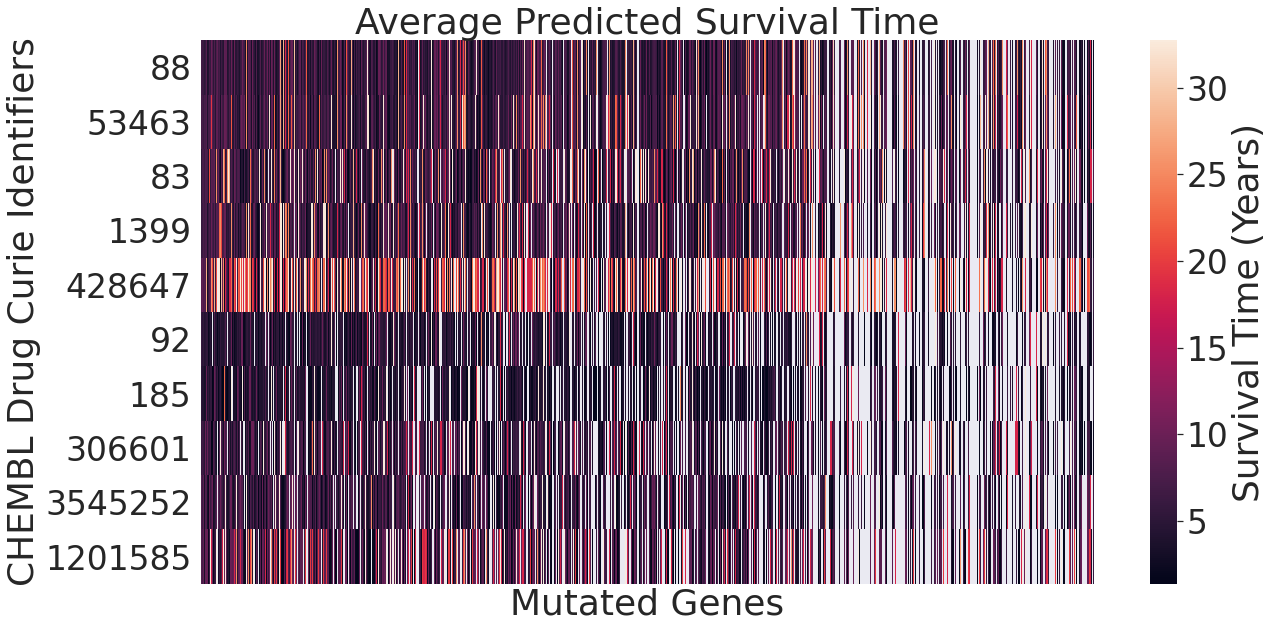

In [58]:
f, ax = plt.subplots(figsize=(20,10))
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(font_scale=3)
#f, ax = plt.subplots(figsize=(9, 6))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(heat_df.T, xticklabels=False, yticklabels=True, cbar_kws={'label': 'Survival Time (Years)'}, mask=heat_df.T.isna())
ax.set_ylabel('CHEMBL Drug Curie Identifiers')
ax.set_xlabel('Mutated Genes')
ax.set_title('Average Predicted Survival Time')
ax.labelsize='large'
ax.titlesize='large'
plt.show()

In [57]:
# Transform into good result dict
dw_dict = {}
for year, res in drug_contribs.items():
  contrib_dict = {}
  for contrib, drug in res:
    contrib_dict[drug[13:]] = contrib
  dw_dict[year[:-2]] = contrib_dict

In [30]:
con_df = pd.DataFrame.from_dict(dw_dict)

In [31]:
con_df

,2,10,5,1
53463,5.557250e-03,0.010110,-4.014194e-03,-0.001311
83,3.887515e-03,-0.001997,2.125091e-03,0.002860
1399,-3.828813e-03,0.001981,-2.094773e-03,-0.001034
428647,-3.661983e-03,0.005165,-1.899928e-03,0.000566
185,2.560277e-03,-0.001165,-2.101228e-03,-0.001754
88,-2.388158e-03,0.006598,1.952844e-03,-0.002971
92,1.185845e-03,-0.003651,4.013423e-03,0.002350
1201585,8.374794e-05,0.000433,-6.652837e-05,0.000077
3545252,6.821499e-05,-0.000240,-5.815963e-05,-0.001651
1444,5.826081e-05,0.001211,-1.239433e-05,-0.000166


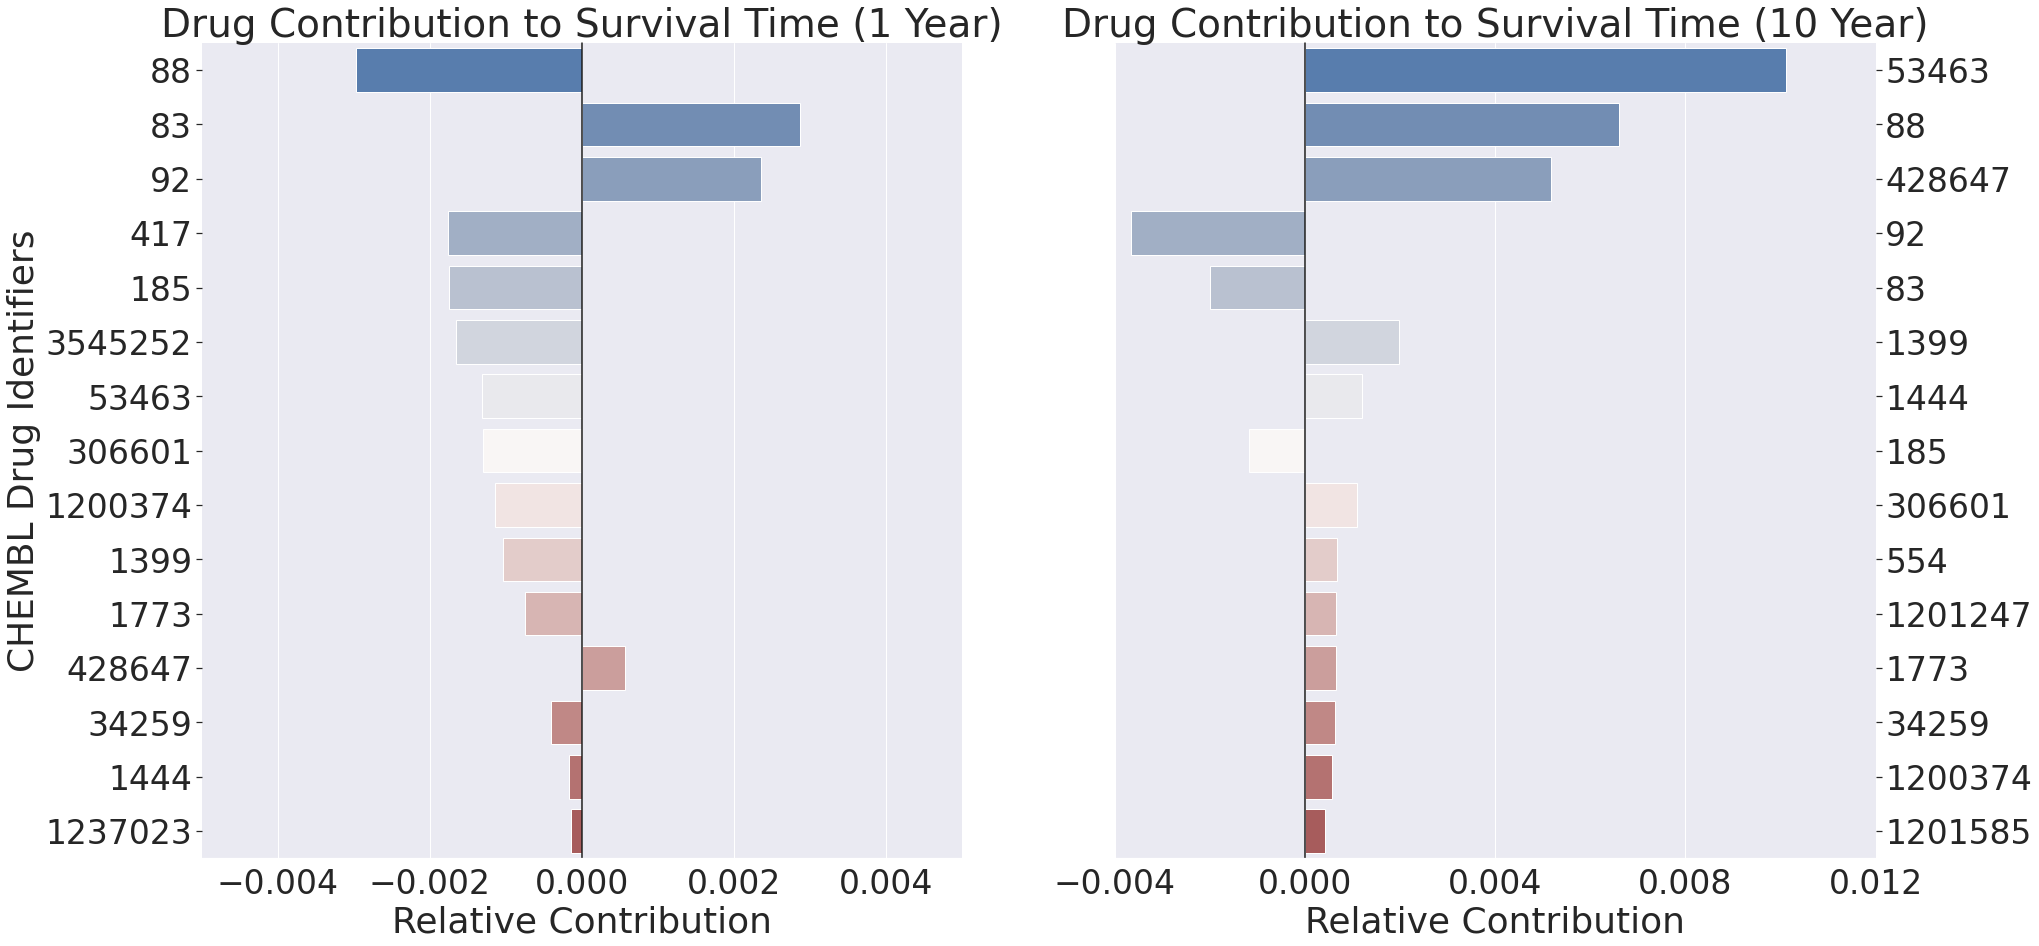

In [32]:
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharex=False)
#sns.set_theme(style="white")
sns.set(font_scale=3.25)
sns.set_style('white', {'font.family':'serif', 'font.serif':'Times New Roman'})
for i, _ax in zip([1,10], [ax1, ax2]):
  df = con_df.sort_values(by=str(i), key=abs, ascending=False).head(15)
  sns.barplot(x=str(i), y=df.index, data=df, orient='h' , palette='vlag', ax=_ax)
#sns.set_color_codes('muted')
#sns.barplot(x='2', y=df_1.index, data=df_1, orient='h' ,color='b')
  _ax.axvline(0, color="k", clip_on=False)
  _ax.set_xlabel('Relative Contribution')
  _ax.labelsize='large'
  _ax.titlesize='large'
  if i == 1:
    _ax.set_xlim((-.005, .005))
    _ax.set_ylabel('CHEMBL Drug Identifiers')
    _ax.yaxis.tick_left()
  else:
    _ax.set_xlim((-.004, .012))
    _ax.yaxis.set_label_position("right")
    _ax.yaxis.tick_right()
    _ax.set_xticks(np.arange(-.004, .016, .004))
  _ax.set_title('Drug Contribution to Survival Time ({0} Year)'.format(i))
sns.despine(left=True, bottom=False, right=True)

# Make the PairGrid
#ax = sns.PairGrid(con_df, x_vars=con_df.columns, y_vars=con_df.index, height=10, aspect=.25)
# Draw a dot plot using the stripplot function
#ax.map(sns.stripplot, size=10, orient="h", jitter=False,
#      palette="flare_r", linewidth=1, edgecolor="w")